# A2Q2: Penguin or not a penguin?

In this question, we will work with .ppm image files. More common formats like JPEG or PNG images are either lossy or use compression (or both), and dealing with that is completely irrelevant to the cryptography in the question, and is also tedious and annoying. PPM files are good for this question because they are uncompressed, lossless bitmap files, making it easy to see patterns that may emerge when images are improperly encrypted.

In this Jupyter notebook, we provide you with functions that do all of the image processing and displaying for you. Note that some operating systems do not have built-in programs for viewing .ppm image files (macOS does, Windows does not). For this reason, to view your encrypted (or decrypted) images, it may be easiest to use the `display_image()` function provided in this notebook. To do this, open up a new cell and type `display_image("file_name.ppm")`

In [2]:
import cv2
import matplotlib.pyplot as plt
import os
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives import padding

## Reading and writing image files

First, we need to be able to read in .ppm files. A .ppm file consists of a header and image data. The header is on the first three lines of the file. The first line contains the "magic number" (in our case, P6), which determines the file type. The second line contains the width and length of the image, in number of pixels. The third line consists of an integer between 0 and 255, which represents the maximal value that each component of an RGB value can take.

When given the name of an existing .ppm file (in the correct directory), the following `read_in_image` function parses out the header, and returns both the header and the image data. All are given as bytestrings. For this question, you will only ever need to work with the image data. The header is only included because it needs to be written back to the encryption/decryption of a .ppm file for formatting reasons.

In [3]:
def read_in_image(filename):
    with open(filename, "rb") as fhin:
        header1 = fhin.readline()
        header2 = fhin.readline()
        header3 = fhin.readline()
        image = fhin.read()
    return (header1, header2, header3, image)

We also need to be able to write .ppm files. The following `write_ppm_file` function does exactly that: when given a file name, the three header lines (the exact same ones, in the same order, that are output from the `read_in_image` function), and a bytestring consisting of image data, it formats these into a .ppm file with the given file name.

In [4]:
def write_ppm_file(filename, header1, header2, header3, image):
    with open(filename, 'wb') as fhout:
        fhout.write(header1)
        fhout.write(header2)
        fhout.write(header3)
        fhout.write(image)

Finally, we need a way to display images. The following `display_image` function does that. When given the name of a .ppm file in the correct directory, this function displays the image encoded in the file.

In [5]:
def display_image(image_name):
    img = cv2.imread(image_name)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

Let's view one of your image files: (make sure you've uploaded your 4 .ppm files to this Jupyter server)

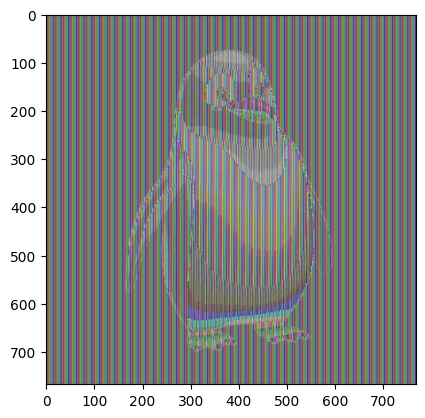

In [10]:
display_image("./a2q2ciphertexts/image4.ppm")

## Basic encryption functions

Now we will see some basic encryption functions that you can use without having to worry too much about how to use the cryptography library in Python.

The following function `AES_encrypt_one_block` uses AES to encrypt a single message block. It takes in a 256-bit (32 byte) key and a 128-bit (16 byte) message block and outputs a 128-bit (16 byte) ciphertext. The key, message, and ciphertext are all formatted as bytestrings. This is the block cipher that will be used as the basis for the modes of operation which are implemented below.

Note: If you look closely, you'll see that we are running the library implementation of AES in ECB mode. This is because running ECB mode on a single block is exactly the same as running the one-block version of a single block. We're doing it this way because this is the easiest way to access it from the library. This is unimportant and will not affect your work.

In [11]:
def AES_encrypt_one_block(key, block):
    cipher = Cipher(algorithms.AES(key), modes.ECB())
    encryptor = cipher.encryptor()
    ct = encryptor.update(block) + encryptor.finalize()
    return ct

The following function `AES_decrypt_one_block` uses AES to decrypt a single message block. It takes in a 256-bit (32 byte) key and a 128-bit (16 byte) ciphertext block and outputs a 128-bit (16 byte) message block. The key, message, and ciphertext are all formatted as bytestrings. If you write your own decryption algorithm for one of the modes of operation below, this is the block cipher decryption function you should use.

In [12]:
def AES_decrypt_one_block(key, block):
    cipher = Cipher(algorithms.AES(key), modes.ECB())
    decryptor = cipher.decryptor()
    pt = decryptor.update(block) + decryptor.finalize()
    return pt

Recall that when using a block cipher, the length of the message needs to be an integer number of blocks. If this is not the case, then a padding scheme is applied to the message to elongate it. In particular, this must be done to the image data before it can be encrypted. This function adds padding to a given bytestring in accordance to the PKCS7 padding scheme. The details of how that works are not important for this question: the only thing you will need to do in regards to padding is call either this function (to add padding) or the next function (to remove padding).

In [13]:
def add_padding(data):
    padder = padding.PKCS7(128).padder()
    padded_data = padder.update(data)
    padded_data += padder.finalize()
    return padded_data

This function removes padding from a bytestring that has been padded in accordance to the PKCS7 padding scheme. In particular, this must be done to decrypted image data before it can be displayed. 

In [14]:
def remove_padding(padded_data):
    unpadder = padding.PKCS7(128).unpadder()
    data = unpadder.update(padded_data)
    data += unpadder.finalize()
    return data

## Possibly faulty implementations of block cipher modes of operation

This is our implementation of the **Electronic Code Book** mode of operation. It may or may not be faulty. It takes in two bytestrings: a 256-bit (32 byte) key and a (padded) message, and outputs the corresponding ciphertext as a bytestring.

In [15]:
def ECB_mode(key, padded_data):
    ct = b''
    for i in range(0, len(padded_data), 16):
        ct += AES_encrypt_one_block(key, padded_data[i:i+16])
    return ct

This is our implementation of the **Cipher Block Chaining** mode of operation. It may or may not be faulty. It takes in three bytestrings: a 256-bit (32 byte) key, a 128-bit (16 byte) IV, and a (padded) message, and outputs the corresponding ciphertext as a bytestring.

Note: In the course notes, it specifies that the IV is included as the first block of the ciphertext. We don't do that here. This is for a few reasons:

1. Including the IV in the ciphertext has no impact on the security of the scheme.
2. It makes image encryption/decryption easier if it's not included (less parsing data).
3. In real-world implementations, the IV is often not included, for the reasons mentioned above. It is often left to the user to properly transmit IVs when needed.

In [16]:
def CBC_mode(key, iv, padded_data): 
    ct = b''
    for i in range(0, len(padded_data), 16):
        inputblock = padded_data[i:i+16]
        # Compute x = iv XOR padded_data[i:i+16]
        x = bytes(iv[j] ^ inputblock[j] for j in range(0, 16))
        iv = AES_encrypt_one_block(iv+iv, x)
        ct += iv
    return ct

This is our implementation of the **Output Feedback** mode of operation. It may or may not be faulty. It takes in two bytestrings: a 256-bit (32 byte) key, a 128-bit (16 byte) IV, and a message, and outputs the corresponding ciphertext as a bytestring.

Note: In the course notes, it specifies that the IV is included as the first block of the ciphertext. We don't do that here for the same reasons as noted above for CBC mode.

In [17]:
def OFB_mode(key, iv, padded_data):
    ct = b''
    x = iv
    for i in range(0, len(padded_data), 16):
        x = AES_encrypt_one_block(key, x)
        ct += bytes(iv[j] ^ x[j] for j in range(0, 16))
    return ct

This is our implementation of the **Counter** mode of operation. It may or may not be faulty. It takes in two bytestrings: a 256-bit (32 byte) key, a 96-bit (12 byte) IV, and a message, and outputs the corresponding ciphertext as a bytestring.

Note: In the course notes, it specifies that the IV is included as the first block of the ciphertext. We don't do that here for the same reasons as noted above for CBC mode.

In [18]:
def CTR_mode(key, iv, padded_data): 
    ct = b''
    counter = b'0000'
    for i in range(0, len(padded_data), 16):
        x = AES_encrypt_one_block(key, iv+counter)
        input_block = padded_data[i:i+16]
        ct += bytes(x[j] ^ input_block[j] for j in range(0, 16))
    return ct

## Initialization vectors

Here are the initialization vectors that were used for each of your images:

In [19]:
iv_cbc = bytes.fromhex('9ff981babbdecfbd07091956062cf66f')
iv_ofb = bytes.fromhex('a90f5741ade0a3fa3d74d935790c7538')
iv_ctr = bytes.fromhex('c48f7a0d7bf9e7a03147db84')

## Your workspace for decryption

If you choose to decrypt any of the images, you can use the following code template, filling in the portions written in all caps (and writing the decryption function). If you do this, please submit your decryption function, as well as the resulting image, to Crowdmark as part of your justification as to why one of the given images is/isn't the encryption of a penguin.

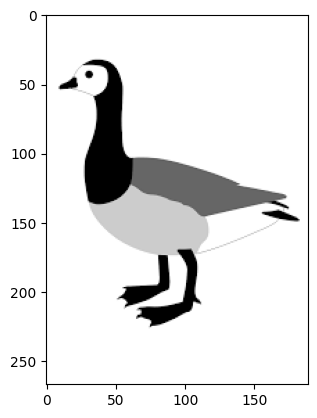

In [31]:
def CBC_mode_decrypt_buggy(key, iv, ciphertext):
    pt = b'' 
    for i in range(0, len(ciphertext), 16):
        ctblock = ciphertext[i:i+16]
        x = AES_decrypt_one_block(iv+iv, ctblock)
        x = bytes(iv[j] ^ x[j] for j in range(16))
        pt += x
        iv = ctblock

    return pt

(header1, header2, header3, image) = read_in_image("a2q2ciphertexts/image2.ppm")
decrypted_image = CBC_mode_decrypt_buggy(None, iv_cbc, image)
write_ppm_file("decrypted_image2.ppm", header1, header2, header3, decrypted_image)
display_image("decrypted_image2.ppm")

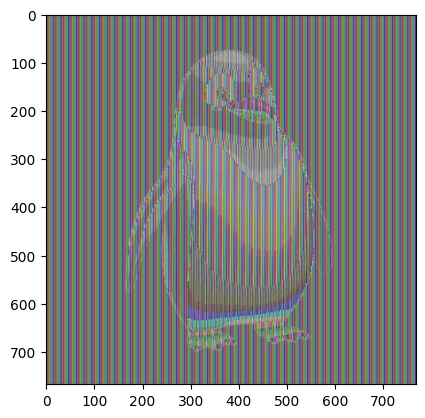

In [44]:
def CTR_mode(key, iv, padded_data): 
    ct = b''
    counter = b'0000'
    for i in range(0, len(padded_data), 16):
        x = AES_encrypt_one_block(key, iv+counter)
        input_block = padded_data[i:i+16]
        ct += bytes(x[j] ^ input_block[j] for j in range(0, 16))
    return ct

def CTR_mode_decrypt_buggy(key, iv, ciphertext):
    pt = b''
    counter = b'0000'
    for i in range(0, len(ciphertext), 16):
        x = AES_decrypt_one_block(key, iv+counter)
        ct_block = ciphertext[i:i+16]
        pt += bytes(x[j] ^ ct_block[j] for j in range(16))
    return pt


dummy_key = bytes.fromhex('00000000000000000000000000000000')

(goose_header1, goose_header2, goose_header3, goose_image) = read_in_image("DECRYPTED_IMAGE.ppm")
(image4_header1, image4_header2, image4_header3, image4_image) = read_in_image("./a2q2ciphertexts/image4.ppm")
encrypted_goose_image = CTR_mode(dummy_key, iv_ctr, goose_image)

write_ppm_file("encrypted_goose.ppm", goose_header1, goose_header2, goose_header3, encrypted_goose_image)
#display_image("encrypted_goose.ppm")

# xor the encrypted image with the original image4.ppm to get the keystream
keystream = bytes(x ^ y for x, y in zip(goose_image, image4_image))

#write_ppm_file("KEYSTREAM.ppm", goose_header1, goose_header2, goose_header3, image4_image)

#display_image("KEYSTREAM.ppm")

display_image("a2q2ciphertexts/image4.ppm")

In [ ]:
(header1, header2, header3, image) = read_in_image("IMAGE_TO_DECRYPT.ppm")

padded_image = YOUR_DECRYPTION_FUNCTION(key, INSERT_IV_HERE, image)

pt = remove_padding(padded_image)

write_ppm_file("DECRYPTED_IMAGE.ppm", header1, header2, header3, pt)
display_image("DECRYPTED_IMAGE.ppm")